# Map query data

In [1]:
import os
import sys
sys.path.insert(0, "/home/aidin/Documents/tum_courses/internship/scarches")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas. We strongly suggest to use earlystopping to avoid over-fitting.

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


scgen_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "patience": 20,
    "threshold": 0,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Download Dataset and split into reference dataset and query dataset

In [5]:
#url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
#output = 'pancreas.h5ad'
#gdown.download(url, output, quiet=False)

In [6]:
adata_all = sc.read('pancreas.h5ad')

This line makes sure that count data is in the adata.X.

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

In [8]:
source_adata.obs

,batch,study,cell_type,size_factors
index,,,,
0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,1.307300e+04
1-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,1.722700e+04
2-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,7.844000e+03
3-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,1.096600e+04
4-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,8.815000e+03
...,...,...,...,...
633-1-0,0,Pancreas Fluidigm C1,Pancreas Alpha,9.318808e+05
634-1-0,0,Pancreas Fluidigm C1,Pancreas Beta,1.282420e+06
635-1-0,0,Pancreas Fluidigm C1,Pancreas Beta,1.378794e+06


In [9]:
target_adata.obs

,batch,study,cell_type,size_factors
index,,,,
0-1-0-0-0,0,Pancreas CelSeq2,Pancreas Alpha,15213.940430
2-1-0-0-0,0,Pancreas CelSeq2,Pancreas Delta,11714.072266
3-1-0-0-0,0,Pancreas CelSeq2,Pancreas Beta,26895.630859
4-1-0-0-0,0,Pancreas CelSeq2,Pancreas Ductal,12899.861328
5-1-0-0-0,0,Pancreas CelSeq2,Pancreas Ductal,17666.962891
...,...,...,...,...
2984-1,1,Pancreas SS2,Pancreas Gamma,221018.000000
2985-1,1,Pancreas SS2,Pancreas Alpha,161140.000000
2986-1,1,Pancreas SS2,Pancreas Delta,144527.000000


### Create SCGEN model and train it on reference dataset

Preprocess reference dataset.

In [10]:
sca.dataset.setup_anndata(source_adata, batch_key=condition_key)

INFO     Using batches from adata.obs["study"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [11]:
source_adata.obs

,batch,study,cell_type,size_factors,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
index,,,,,,,,
0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,1.307300e+04,2,0,6.514010,0.888143
1-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,1.722700e+04,2,0,6.514010,0.888143
2-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,7.844000e+03,2,0,6.514010,0.888143
3-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,1.096600e+04,2,0,6.514010,0.888143
4-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,8.815000e+03,2,0,6.514010,0.888143
...,...,...,...,...,...,...,...,...
633-1-0,0,Pancreas Fluidigm C1,Pancreas Alpha,9.318808e+05,1,0,11.745523,0.253432
634-1-0,0,Pancreas Fluidigm C1,Pancreas Beta,1.282420e+06,1,0,11.745523,0.253432
635-1-0,0,Pancreas Fluidigm C1,Pancreas Beta,1.378794e+06,1,0,11.745523,0.253432


Create the scgen model instance

In [12]:
network = sca.models.SCGEN(adata = source_adata, 
                           hidden_layer_sizes=[128,128])


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out: 1000 128
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out 10 128
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [13]:
network.train(n_epochs=scgen_epochs, early_stopping_kwargs = early_stopping_kwargs)

 |███████-------------| 35.8%  - epoch_loss: 114036.9306876347 - val_loss: 101446.935876094965625000
ADJUSTED LR
 |███████-------------| 39.2%  - epoch_loss: 111857.6659962621 - val_loss: 106405.3719510165
ADJUSTED LR
 |████████------------| 40.6%  - epoch_loss: 112007.8940143454 - val_loss: 108689.1129862467
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 181


### reference data latent representation

In [14]:
reference_latent = sc.AnnData(network.to_latent())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


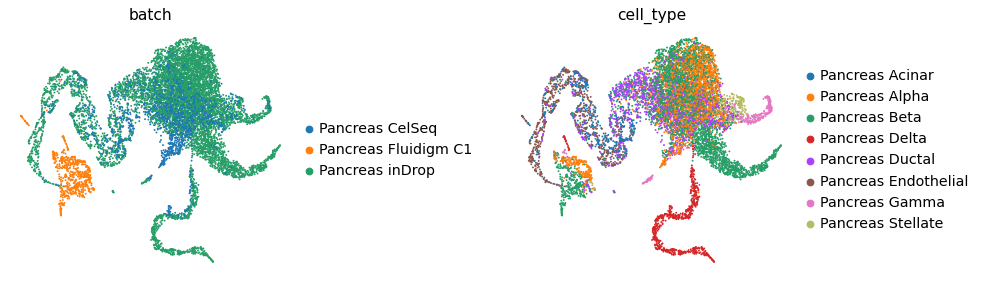

In [15]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [16]:
corrected_reference_adata = network.batch_removal(source_adata, batch_key="study", cell_label_key="cell_type")

         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'cell_type' as categorical


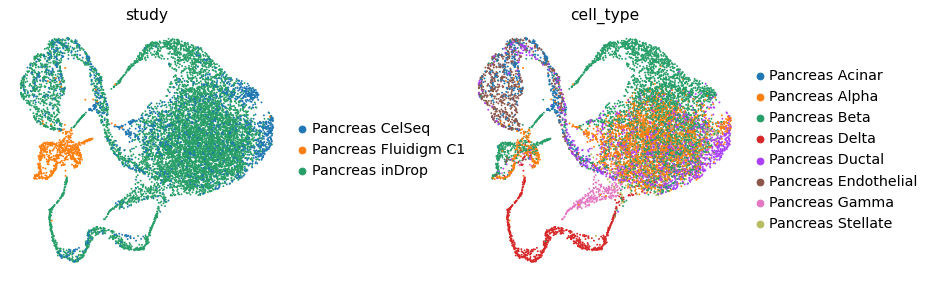

In [17]:
sc.pp.neighbors(corrected_reference_adata)
sc.tl.umap(corrected_reference_adata)
sc.pl.umap(corrected_reference_adata, color=["study", "cell_type"], wspace=.5, frameon=False)

After pretraining the model can be saved for later use

In [18]:
ref_path = 'ref_model/'
network.save(ref_path, overwrite=True)

### Project query on top of the reference

In [19]:
integrated_query = sca.models.SCGEN.map_query_data(reference_model = ref_path,
                                                   corrected_reference = corrected_reference_adata,
                                                   query = target_adata)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out: 1000 128
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out 10 128
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [20]:
integrated_query.obs

,batch,study,cell_type,size_factors,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var,concatenated_batch
index,,,,,,,,,
0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,13073.0,2.0,0.0,6.51401,0.888143,0
1-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,17227.0,2.0,0.0,6.51401,0.888143,0
2-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,7844.0,2.0,0.0,6.51401,0.888143,0
3-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,10966.0,2.0,0.0,6.51401,0.888143,0
4-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,8815.0,2.0,0.0,6.51401,0.888143,0
...,...,...,...,...,...,...,...,...,...
2984-1,1,Pancreas SS2,Pancreas Gamma,221018.0,NaN,NaN,NaN,NaN,1
2985-1,1,Pancreas SS2,Pancreas Alpha,161140.0,NaN,NaN,NaN,NaN,1
2986-1,1,Pancreas SS2,Pancreas Delta,144527.0,NaN,NaN,NaN,NaN,1


### Plot latent space of integrated_query

In [21]:
adata_full = source_adata.concatenate(target_adata)

integrated_query_latent = sc.AnnData(network.to_latent(integrated_query.X))
integrated_query_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
integrated_query_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

In [22]:
adata_full.obs

,batch,study,cell_type,size_factors,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var
index,,,,,,,,
0-0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,13073.0,2.0,0.0,6.51401,0.888143
1-0-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,17227.0,2.0,0.0,6.51401,0.888143
2-0-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,7844.0,2.0,0.0,6.51401,0.888143
3-0-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,10966.0,2.0,0.0,6.51401,0.888143
4-0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,8815.0,2.0,0.0,6.51401,0.888143
...,...,...,...,...,...,...,...,...
2984-1-1,1,Pancreas SS2,Pancreas Gamma,221018.0,NaN,NaN,NaN,NaN
2985-1-1,1,Pancreas SS2,Pancreas Alpha,161140.0,NaN,NaN,NaN,NaN
2986-1-1,1,Pancreas SS2,Pancreas Delta,144527.0,NaN,NaN,NaN,NaN


In [23]:
integrated_query_latent.obs

,cell_type,batch
0,Pancreas Endothelial,Pancreas inDrop
1,Pancreas Acinar,Pancreas inDrop
2,Pancreas Acinar,Pancreas inDrop
3,Pancreas Acinar,Pancreas inDrop
4,Pancreas Endothelial,Pancreas inDrop
...,...,...
15676,Pancreas Gamma,Pancreas SS2
15677,Pancreas Alpha,Pancreas SS2
15678,Pancreas Delta,Pancreas SS2
15679,Pancreas Alpha,Pancreas SS2


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

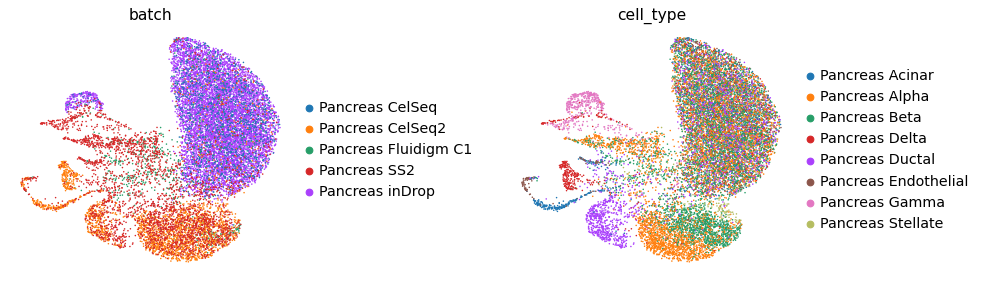

In [24]:
sc.pp.neighbors(integrated_query_latent)
sc.tl.leiden(integrated_query_latent)
sc.tl.umap(integrated_query_latent)
plt.figure()
sc.pl.umap(
    integrated_query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

### Plot uncorrected reference + query latent space

In [31]:
full_latent = sc.AnnData(network.to_latent(adata_full.X))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

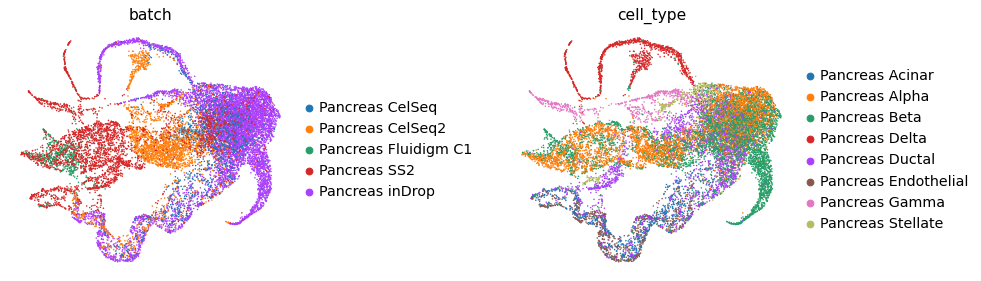

In [32]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

### Plot uncorrected reference + query gene expression space

<Figure size 320x320 with 0 Axes>

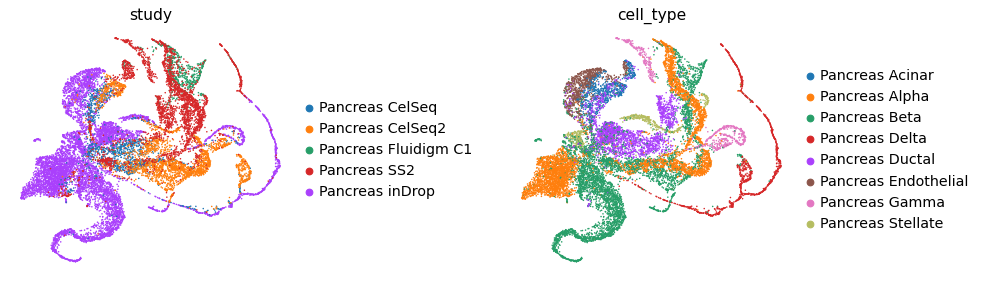

In [28]:
sc.pp.neighbors(adata_full)
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)
plt.figure()
sc.pl.umap(
    adata_full,
    color=["study", "cell_type"],
    frameon=False,
    wspace=0.6,
)

### Plot corrected reference + query gene expression space

In [25]:
integrated_query_corrected = sc.AnnData(integrated_query)
integrated_query_corrected.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
integrated_query_corrected.obs['batch'] = adata_full.obs[condition_key].tolist()

         Falling back to preprocessing with `sc.pp.pca` and default params.
... storing 'batch' as categorical
... storing 'study' as categorical
... storing 'cell_type' as categorical


<Figure size 320x320 with 0 Axes>

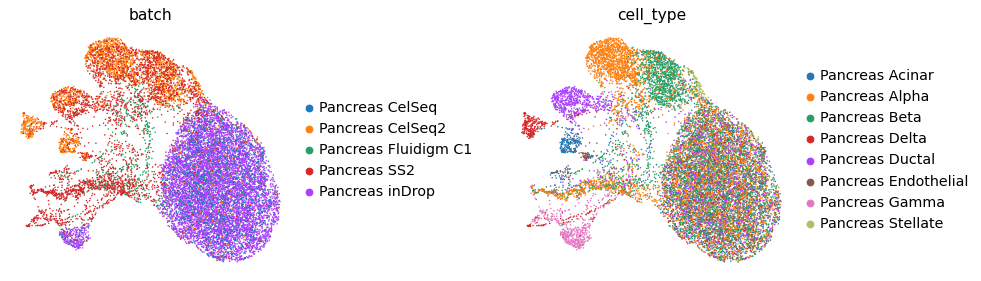

In [26]:
sc.pp.neighbors(integrated_query_corrected)
sc.tl.leiden(integrated_query_corrected)
sc.tl.umap(integrated_query_corrected)
plt.figure()
sc.pl.umap(
    integrated_query_corrected,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)